In [58]:
import pandas as pd
import numpy as np
df = pd.read_csv('S&P500.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-30,2251.610107,2253.580078,2233.620117,2238.830078,2238.830078,2671550000
1,2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2,2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
3,2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
4,2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
...,...,...,...,...,...,...,...
247,2017-12-22,2684.219971,2685.350098,2678.129883,2683.340088,2683.340088,2401030000
248,2017-12-26,2679.090088,2682.739990,2677.959961,2680.500000,2680.500000,1970660000
249,2017-12-27,2682.100098,2685.639893,2678.909912,2682.620117,2682.620117,2202900000
250,2017-12-28,2686.100098,2687.659912,2682.689941,2687.540039,2687.540039,2174890000


In [59]:
# Assuming df is your DataFrame
df['Volatility'] = df['Adj Close'].pct_change().rolling(window=2).std() * 100


In [60]:
volatility  = df[['Date','Volatility']]
import datetime
volatility['Date'] = pd.to_datetime(volatility['Date'])
volatility.set_index('Date', inplace = True)

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


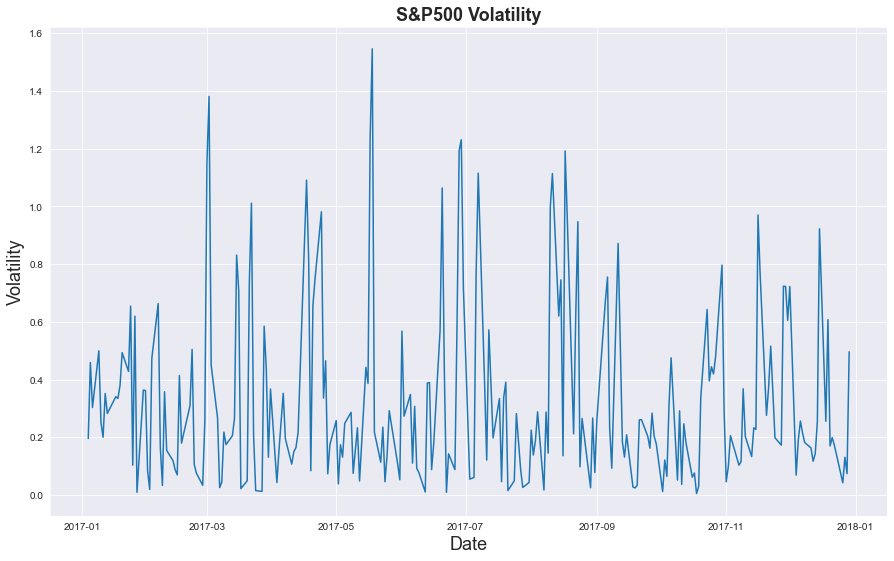

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.figure(figsize=(15,9))
plt.plot(volatility['Volatility'])
plt.title("S&P500 Volatility", fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Volatility', fontsize=18)
plt.show()

In [62]:
price = df[['Volatility']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Volatility  250 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [63]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
#price['Adj Close'] = scaler.fit_transform(price['Adj Close'].values.reshape(-1,1))
price['Volatility'] = scaler.fit_transform(price['Volatility'].values.reshape(-1,1))

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [64]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    x_test = data[train_set_size:, :-1, :]
    y_test = data[train_set_size:, -1, :]
    return x_train, y_train, x_test, y_test

In [65]:
lookback = 20  # Number of previous days to consider
data = split_data(price, lookback)

In [66]:
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape =',x_train.shape)
print('y_train.shape =',y_train.shape)
print('x_test.shape =',x_test.shape)
print('y_test.shape =',y_test.shape)

x_train.shape = (186, 19, 1)
y_train.shape = (186, 1)
x_test.shape = (46, 19, 1)
y_test.shape = (46, 1)


In [67]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [68]:
print(torch.max(x_train), torch.min(x_train), torch.isnan(x_train).any())

tensor(nan) tensor(nan) tensor(True)


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.v = nn.Parameter(torch.rand(hidden_dim, 1))

    def forward(self, hidden, encoder_outputs):
        energy = torch.matmul(hidden, encoder_outputs.permute(1, 2, 0))
        attention = torch.softmax(energy, dim=2)
        attention = attention.permute(0, 2, 1)
        return attention


class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMWithAttention, self).__init__()
        # 修改这里的 nn.Linear 为 nn.Linear
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 添加维度以匹配 nn.LSTM 的输入维度
        embedded = self.embedding(x.squeeze(2)).unsqueeze(1)
        output, (hidden, cell) = self.lstm(embedded)
        attention_weights = self.attention(hidden[-1], output.permute(1, 0, 2))
        weighted = torch.matmul(attention_weights.squeeze(2), output.squeeze(1))

        fc_output = self.fc(weighted.squeeze(1))
        return fc_output

# Example usage
input_dim = 19
hidden_dim = 512  # adjust based on your model complexity
hidden_dim = int(hidden_dim)
output_dim = 1  # adjust based on your output data
num_epochs = 100
hist = np.zeros(num_epochs)

model = LSTMWithAttention(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

for t in range(num_epochs):
    optimizer.zero_grad()
    x_train = torch.where(torch.isnan(x_train), torch.tensor(0.0), x_train)
    y_train_pred = model(x_train)
    print("y_train_pred shape:", y_train_pred.shape)
    print("y_train shape:", y_train.shape)
    # 将 NumPy 数组转换为 PyTorch 张量
    y_train = torch.tensor(y_train, dtype=torch.float32)

    # 然后检查维度是否匹配
    print("y_train_pred shape:", y_train_pred.shape)
    print("y_train shape:", y_train.shape)

    # 计算损失
    loss = criterion(y_train_pred.squeeze(), y_train.squeeze())
    loss.backward()
    
    optimizer.step()

    print(f'Epoch {t + 1}/{num_epochs}, Loss: {loss.item()}')
    hist[t] = loss.item()


y_train_pred shape: torch.Size([186, 1])
y_train shape: (186, 1)
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
Epoch 1/100, Loss: 39.52011489868164
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
Epoch 2/100, Loss: 1458.6114501953125
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
Epoch 3/100, Loss: 116.4515380859375


c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
Epoch 4/100, Loss: 253.41859436035156
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
Epoch 5/100, Loss: 691.86865234375
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
Epoch 6/100, Loss: 503.1789245605469
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
Epoch 7/100, Loss: 143.3205108642578
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
y_train_pred shape: torch.Size([186, 1])
y_train shape: torch.Size([186, 1])
Epoch 8/100, Loss: 0.17636649310588837
y_train_pred shape: torch.Size([186, 1])
y_t

In [70]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

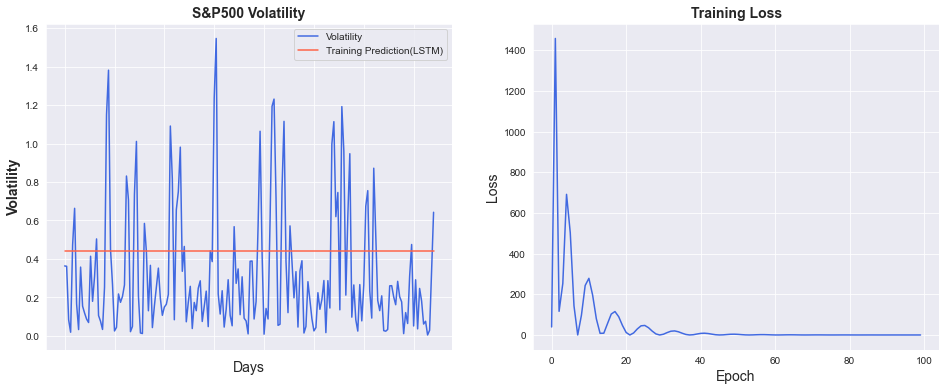

In [71]:
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace = 0.2, wspace=0.2)

plt.subplot(1,2,1)
ax = sns.lineplot(x= original.index, y= original[0], label='Volatility', color='royalblue')
ax = sns.lineplot(x= predict.index, y= predict[0], label='Training Prediction(LSTM)', color='tomato')
ax.set_title('S&P500 Volatility', size = 14, fontweight='bold')
ax.set_xlabel('Days', size = 14)
ax.set_ylabel('Volatility', size = 14, fontweight='bold')
ax.set_xticklabels('', size = 10)

plt.subplot(1,2,2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size=14)
ax.set_ylabel("Loss", size=14)
ax.set_title("Training Loss", size = 14, fontweight = 'bold')
fig.set_figheight(6)
fig.set_figwidth(16)